# Applying ARCH/GARCH Models in Foreign Exchange (FX) Markets 

## Introduction

## 1. Fetching Data from FRED
In this section, we'll use the FRED API to fetch historical FX rate data for the EUR/USD pair.

In [251]:
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model
import seaborn as sns
from fredapi import Fred
import os

api_key = os.getenv('FRED_API_KEY', '060213f8f9bc0f09d86c251b43f3e1dc')
fred = Fred(api_key=api_key)

In [252]:
# Retrieve EUR/USD Exchange Rate
eur_usd = fred.get_series('DEXUSEU')

# Retrieve US Federal Reserve Interest Rate
us_interest_rate = fred.get_series('FEDFUNDS')

# Retrieve ECB Interest Rate
# Assuming you have a CSV file downloaded from ECB or use an API
ecb_interest_rate = pd.read_csv(r'D:\Projects\ECB Data Portal_20240812162427(1).csv')

# Check the columns in the ECB dataset
print(ecb_interest_rate.columns)

Index(['DATE', 'TIME PERIOD',
       'Deposit facility - date of changes (raw data) - Level (FM.D.U2.EUR.4F.KR.DFR.LEV)',
       'Marginal lending facility - date of changes (raw data) - Level (FM.D.U2.EUR.4F.KR.MLFR.LEV)',
       'Main refinancing operations - Minimum bid rate/fixed rate (date of changes) - Level (FM.D.U2.EUR.4F.KR.MRR_RT.LEV)'],
      dtype='object')


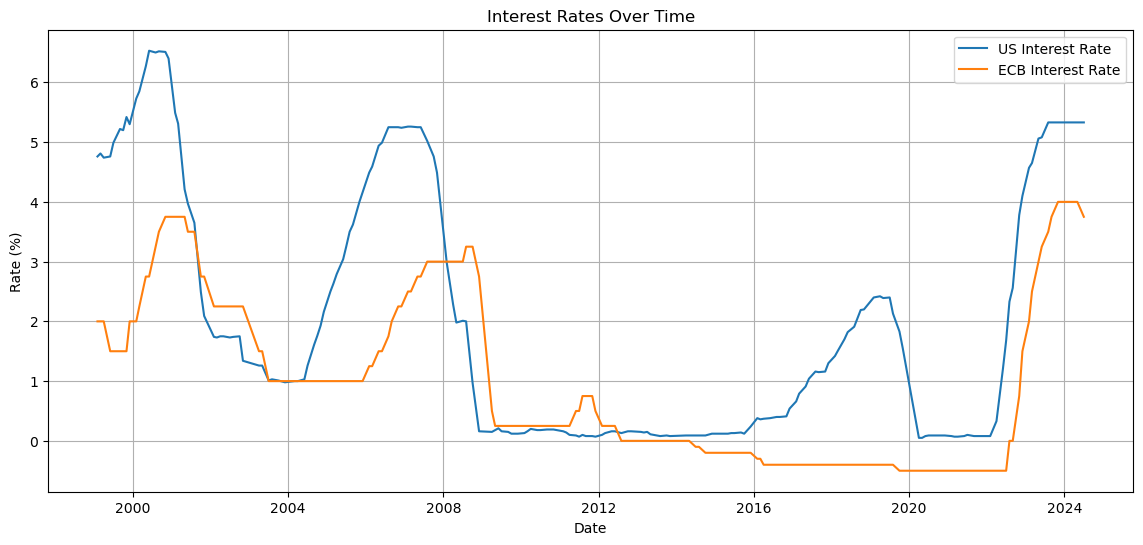

In [253]:
# Convert the 'DATE' column to a datetime format
ecb_interest_rate['DATE'] = pd.to_datetime(ecb_interest_rate['DATE'])

# Create a DataFrame with the merged data
merged_data = pd.DataFrame({
    'Date': eur_usd.index,
    'EUR/USD': eur_usd.values,
    'US Interest Rate': us_interest_rate.reindex(eur_usd.index).values,
    'ECB Interest Rate': ecb_interest_rate.set_index('DATE').reindex(eur_usd.index)['Deposit facility - date of changes (raw data) - Level (FM.D.U2.EUR.4F.KR.DFR.LEV)'].values
})

# Drop any missing values
merged_data.dropna(inplace=True)

# Plot the interest rates over time
plt.figure(figsize=(14, 6))
plt.plot(merged_data['Date'], merged_data['US Interest Rate'], label='US Interest Rate')
plt.plot(merged_data['Date'], merged_data['ECB Interest Rate'], label='ECB Interest Rate')
plt.title('Interest Rates Over Time')
plt.xlabel('Date')
plt.ylabel('Rate (%)')
plt.legend()
plt.grid(True)
plt.show()

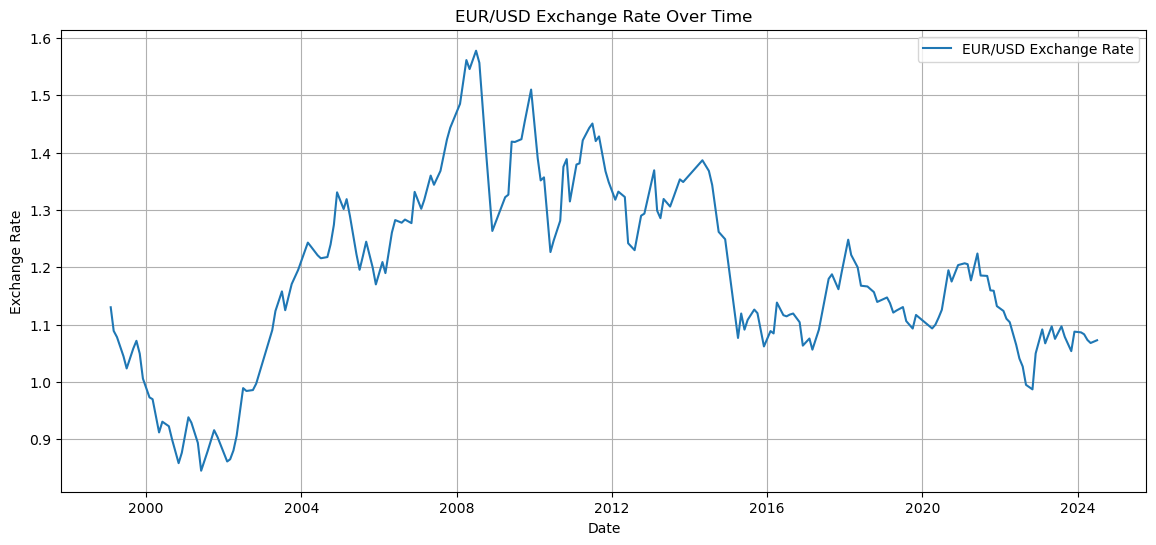

In [254]:
# Plot the EUR/USD exchange rate separately
plt.figure(figsize=(14, 6))
plt.plot(merged_data['Date'], merged_data['EUR/USD'], label='EUR/USD Exchange Rate')
plt.title('EUR/USD Exchange Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.show()

                    EUR/USD  US Interest Rate  ECB Interest Rate
EUR/USD            1.000000         -0.384550          -0.229081
US Interest Rate  -0.384550          1.000000           0.771772
ECB Interest Rate -0.229081          0.771772           1.000000


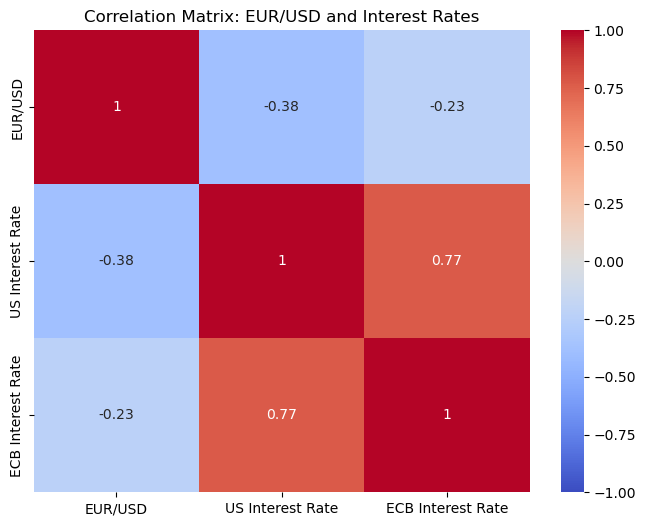

In [255]:
# Calculate the correlation matrix
correlation_matrix = merged_data[['EUR/USD', 'US Interest Rate', 'ECB Interest Rate']].corr()

# Print the correlation matrix
print(correlation_matrix)

# Plot the heatmap of the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

plt.title('Correlation Matrix: EUR/USD and Interest Rates')
plt.show()

In [256]:
# Assuming you have EUR/USD and US interest rate data already loaded
# Create a DataFrame with relevant data
data = pd.DataFrame({
    'Date': eur_usd.index,  # Replace eur_usd.index with your EUR/USD series
    'EUR/USD': eur_usd.values,  # Replace eur_usd.values with your EUR/USD series
    'US Interest Rate': us_interest_rate.reindex(eur_usd.index).values,  # Replace us_interest_rate with your US rate series
    'ECB Interest Rate': ecb_interest_rate.set_index('DATE').reindex(eur_usd.index)['Deposit facility - date of changes (raw data) - Level (FM.D.U2.EUR.4F.KR.DFR.LEV)'].values
})

# Filter out rows with invalid values
data = data[(data['EUR/USD'] > 0) & (data['US Interest Rate'] > 0) & (data['ECB Interest Rate'] > 0)]

# Now calculate log returns safely
data['EUR/USD Returns'] = np.log(data['EUR/USD']).diff().dropna()
data['US Interest Rate Returns'] = np.log(data['US Interest Rate']).diff().dropna()
data['ECB Interest Rate Returns'] = np.log(data['ECB Interest Rate']).diff().dropna()

# Drop any remaining NaN values
data.dropna(inplace=True)

                     Constant Mean - GARCH Model Results                      
Dep. Variable:        EUR/USD Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -61.2270
Distribution:                  Normal   AIC:                           130.454
Method:            Maximum Likelihood   BIC:                           141.604
                                        No. Observations:                  120
Date:                Mon, Aug 12 2024   Df Residuals:                      119
Time:                        21:00:55   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu             0.0210  3.273e-02      0.641      0.521 

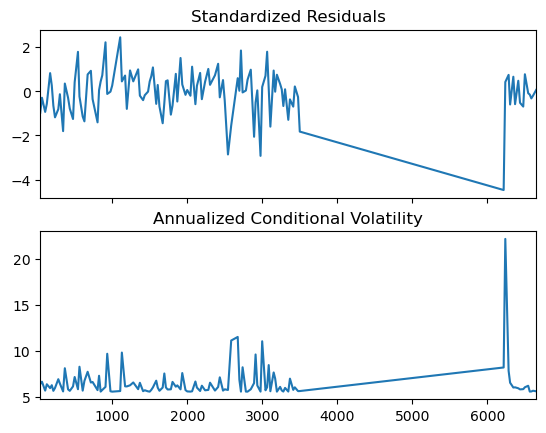

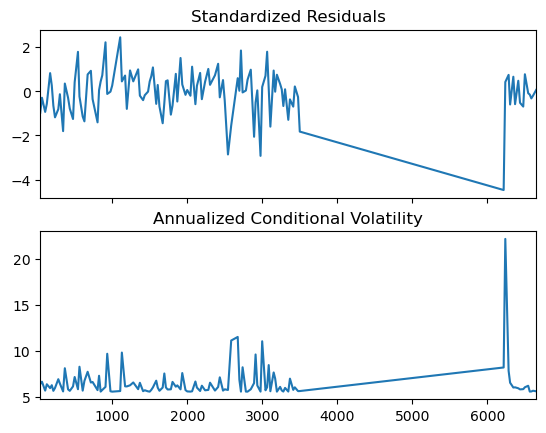

In [257]:
from arch import arch_model
import warnings

# Drop any missing values in the EUR/USD returns
eurusd_returns = data['EUR/USD Returns'].dropna()

# Rescale the returns by multiplying by 10
scaled_returns = eurusd_returns * 10

# Fit a GARCH(1,1) model to the rescaled returns
garch_model = arch_model(scaled_returns, vol='Garch', p=1, q=1, rescale=False)

# Fit the model and store the results
garch_result = garch_model.fit(disp='off')

# Print the summary of the GARCH model results
print(garch_result.summary())

# Plot the conditional volatility
garch_result.plot(annualize='D')

            CPIAUCSL  Inflation Rate
DATE                                
2000-02-01     170.0        0.413467
2000-03-01     171.0        0.588235
2000-04-01     170.9       -0.058480
2000-05-01     171.2        0.175541
2000-06-01     172.2        0.584112


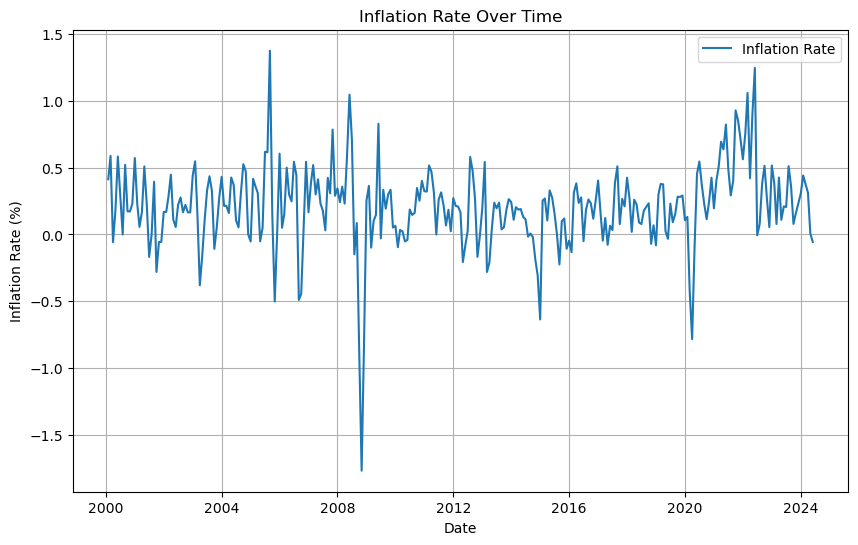

In [258]:
import pandas_datareader.data as web
from datetime import datetime
import matplotlib.pyplot as plt

# Define the start and end dates for fetching data
start = datetime(2000, 1, 1)
end = datetime.now()

# Fetch the Consumer Price Index (CPI)
inflation_data = web.DataReader('CPIAUCSL', 'fred', start, end)

# Calculate the inflation rate as the percentage change of CPI
inflation_data['Inflation Rate'] = inflation_data['CPIAUCSL'].pct_change() * 100

# Drop NaN values that result from the pct_change calculation
inflation_data = inflation_data.dropna()

# Display the first few rows of the data
print(inflation_data.head())

# Plot the Inflation Rate
plt.figure(figsize=(10, 6))
plt.plot(inflation_data.index, inflation_data['Inflation Rate'], label='Inflation Rate')
plt.title('Inflation Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Inflation Rate (%)')
plt.legend()
plt.grid(True)
plt.show()


In [260]:
import statsmodels.api as sm

# Assuming 'EUR/USD Returns' is your dependent variable
# and you have other independent variables in your DataFrame, e.g., 'Interest Rate', 'Inflation Rate'
import pandas_datareader.data as web
from datetime import datetime

# Drop NaN values resulting from the pct_change calculation
inflation_data = inflation_data.dropna()

# Now merge this with your main dataset if necessary
data = data.merge(inflation_data[['Inflation Rate']], left_index=True, right_index=True, how='left')

# Ensure there are no missing values in the merged DataFrame
data = data.dropna(subset=['EUR/USD Returns', 'US Interest Rate', 'ECB Interest Rate', 'Inflation Rate'])

import statsmodels.api as sm

# Prepare the independent variables (X) and dependent variable (y)
X = data[['US Interest Rate', 'ECB Interest Rate', 'Inflation Rate']]
y = data['EUR/USD Returns']

# Drop rows where any value is NaN in either X or y
X, y = X.align(y, join='inner', axis=0)

# Add a constant to the independent variables matrix
X = sm.add_constant(X)

# Check if X or y are empty
if X.empty or y.empty:
    raise ValueError("Independent variables (X) or dependent variable (y) is empty after aligning and dropping NaNs.")

# Run the OLS regression
model = sm.OLS(y, X)
results = model.fit()

# Print the summary of the regression
print(results.summary())

# Optional: plot the regression results
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.scatter(results.fittedvalues, y, edgecolors=(0, 0, 0))
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Fitted')
plt.ylabel('Observed')
plt.title('Regression Fit Plot')
plt.show()

KeyError: ['Inflation Rate']

In [261]:
# Print the structure and the first few rows of the original data DataFrame
print("Original data structure:")
print(data.info())

print("\nFirst few rows of the data DataFrame:")
print(data.head())

# Check if specific columns exist in the data
columns_to_check = ['EUR/USD Returns', 'US Interest Rate', 'ECB Interest Rate', 'Inflation Rate']
for column in columns_to_check:
    if column not in data.columns:
        print(f"Column '{column}' is missing from the data DataFrame.")
    else:
        print(f"Column '{column}' exists with {data[column].count()} non-missing values.")

Original data structure:
<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Date                       0 non-null      datetime64[ns]
 1   EUR/USD                    0 non-null      float64       
 2   US Interest Rate           0 non-null      float64       
 3   ECB Interest Rate          0 non-null      float64       
 4   EUR/USD Returns            0 non-null      float64       
 5   US Interest Rate Returns   0 non-null      float64       
 6   ECB Interest Rate Returns  0 non-null      float64       
 7   Inflation Rate_x           0 non-null      float64       
 8   Inflation Rate_y           0 non-null      float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 0.0+ bytes
None

First few rows of the data DataFrame:
Empty DataFrame
Columns: [Date, EUR/USD, US Interest Rate, ECB Interest Rate, EUR/USD Re